# Homework 3: Reproducibility in Climate Studies

* **Statistics 159/259, Spring 2022**
* **Due 03/23/2023, 23:59PM PT**
* Prof. F. Pérez and GSI F. Sapienza, Department of Statistics, UC Berkeley.
* This assignment is worth a maximum of **50 points**.
* Assignment type: **group homework assignment** (Check on Ed Discussion about group's assignments).

## 2. The West Coast Heat Wave

In 2016 [Dr. Chelle Gentemann](https://cgentemann.github.io) and collaborators published a [paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2016GL071039) on the heat wave in the ocean off the California coast

The analysis was then performed using Matlab to process scientific data. To make Figure 1, here are the following steps:
- Download 4 TB of data from NASA PO.DAAC data archive via FTP
- Go through each day of data and subset to the West Coast Region to reduce size and save each subsetted day
- Go through 2002-2012 and create a daily climatology and save all 365 days of the climatology
- Go through each day of data and calculate the anomaly and save each day's anomaly

This whole process took about 1-2 month. 
Below we will do this using MUR SST data on AWS Open Data Program in a few minutes using Python.

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

Subset all the data to just the West Coast region

In [3]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

### Question 6 [10 points]

Reproduce one of the images in Figure 3. 

Time series of daily SSTs and winds, smoothed with a 30 day running mean, in the northern parts of the CCUS. 

Recreating 3b - SST 1 km offshore


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

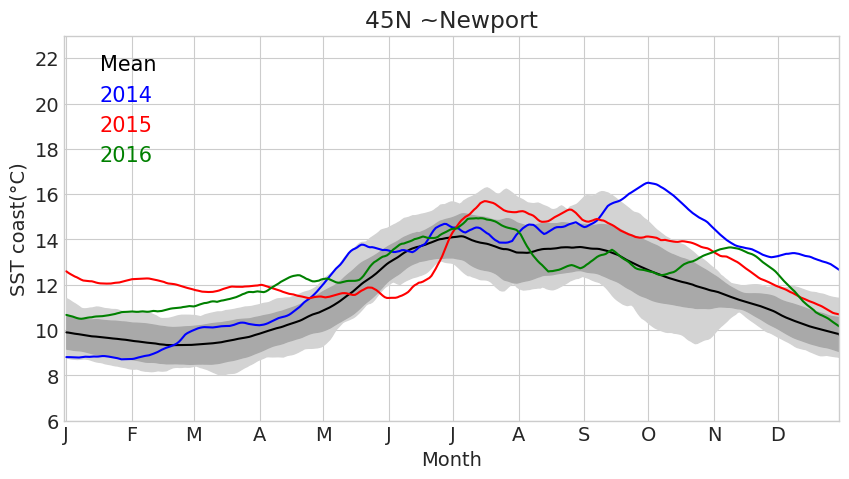

In [21]:
# slice data for the Newport OR
newport = ds.analysed_sst.sel(lat=45, lon = -124, method='nearest')- 273.15
newport = newport.rolling(time=30, center=True).mean()


# create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 5))


# slice data for year 2002-2013
maximum = newport.sel(time=slice('2002', '2013')).groupby('time.dayofyear').max()
minimum = newport.sel(time=slice('2002', '2013')).groupby('time.dayofyear').min()
mean = newport.sel(time=slice('2002', '2013')).groupby('time.dayofyear').mean()
std = newport.sel(time=slice('2002', '2013')).groupby('time.dayofyear').std()
upper_bound = mean + std
lower_bound = mean - std


# plot shaded areas for maximum and minimum values during 2002–2013
ax.fill_between(mean.dayofyear.values, minimum, maximum, color='lightgray')

#  plot shaded areas for ±1 SD around the mean during 2002–2013
ax.fill_between(mean.dayofyear.values, lower_bound, upper_bound, color='darkgray')

# plot mean data from 2002-2013
ax.plot(mean.dayofyear.values, mean, color='k', label='Mean')

# slice data for year 2014, 2015, 2016
years = [2014, 2015, 2016]
color = ['b', 'r', 'g']

for i, year in enumerate(years):
    sst_year = newport.sel(time=str(year))
    sst_smoothed = sst_year.groupby('time.dayofyear').mean()
    ax.plot(sst_smoothed.dayofyear.values, 
            sst_smoothed.values, color=color[i], label=str(year))

# change x-axis label
month_starts = [1,32,61,92,122,153,183,214,245,275,306,336]
month_names = ['J','F','M','A','M','J',
               'J','A','S','O','N','D'] 

ax.set_xticks(month_starts)
ax.set_xticklabels(month_names)


ax.legend(loc='upper left', labelcolor = 'linecolor', fontsize=15, handlelength = 0)
plt.ylim(6,23)
plt.xlim(0,365)
plt.ylabel("SST coast(°C)")
plt.xlabel("Month")
plt.title("45N ~Newport")
plt.savefig('outputs/Q6')
plt.show()

